## The steady Navir-Stokes equation

#### (1.1) The equation and the weak form
The governing PDE is
\begin{equation}
\begin{split}
 - \nu\nabla(\cdot \nabla {\bf u}) + \nabla p = {\bf f}, \quad \text{in}\ \Omega \\
   \nabla\cdot {\bf u} = 0,\quad \text{in}\ \Omega
\end{split}
\end{equation}
where $p(N/m^2)$ is the pressure, ${\bf u} (m/s)$ is the velocity, $\nu$ is the dynamic viscosity, and ${\bf f}$ is the applied body force.
A typical set of boundary conditions on the boundary $\partial\Omega = \Gamma_D\cup \Gamma_N$ can be:
\begin{equation}
\begin{split}
 {\bf u} = {\bf u}_0, \quad \text{on}\ \Gamma_D \\
(\nabla\cdot{\bf u}+p)\cdot\vec{n} = g\quad \text{on}\ \Gamma_N
\end{split}
\end{equation}
### (1.2) The weal form
Given ${\bf f}\in H^{-1}(\Omega)$, find $({\bf u},p)\in H^1_0(\Omega)\times L^2_0(\Omega)$ such that
\begin{equation}
\begin{split}
(\nabla {\bf u}, \nabla {\bf v}) - (\nabla\cdot{\bf v}, p) &= <{\bf f}, {\bf v}>_{H^{-1}(\Omega), H^1_0(\Omega)},\quad \forall {\bf v}\in H^1_0(\Omega) \\
- (\nabla\cdot{\bf u}, q) &= 0,\quad \forall q\in L^2_0(\Omega)
\end{split}
\end{equation}
The above equation is equivalent to the following equation
\begin{equation}
(\nabla {\bf u}, \nabla {\bf v}) - (\nabla\cdot{\bf v}, p) + (\nabla\cdot{\bf u}, q) = <{\bf f}, {\bf v}>,\quad \forall ({\bf v},q)\in V\times Q
\end{equation}

### (1) The PINN 

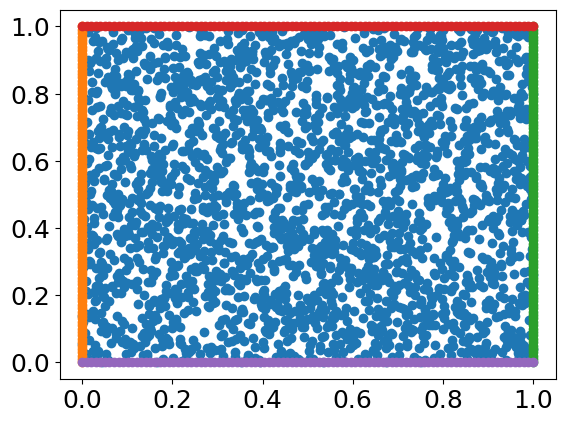

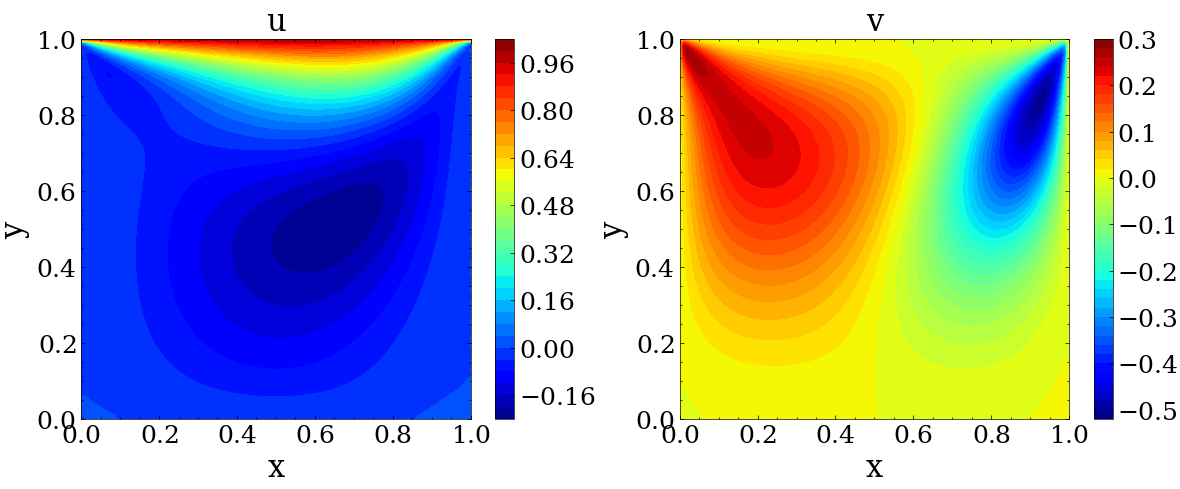

In [1]:
import sys 
sys.path.append("../..") 
import numpy as np
import h5py
import torch
from Utils.GenPoints import Point2D
from Utils.PlotFigure import Plot
import matplotlib.pyplot as plt
#
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     torch.backends.cudnn.deterministic = True
random_seed = 123
device = 'cuda:0'
dtype = torch.float32
setup_seed(random_seed)
problem_name = 'NSteady_lid_cavity'
####################################
# Load data
####################################
data = h5py.File('../../Problems/NS_steady/truth_lid_cavity.mat', 'r')
u_test, v_test = np.array(data['u']), np.array(data['v'])
xx_test, yy_test = np.array(data['xx']).T, np.array(data['yy']).T
x_test = np.vstack((xx_test.flatten(), yy_test.flatten())).T
u_test = torch.tensor(u_test.reshape(-1,1), dtype=dtype)
v_test = torch.tensor(v_test.reshape(-1,1), dtype=dtype)
x_test = torch.tensor(x_test, dtype=dtype)
######################################
# Setups of the problem 
######################################
N_in, N_bd_each_edge = 2500, 100
pointGen = Point2D(x_lb=[0., 0.], x_ub=[1., 1.], dataType=dtype, random_seed=random_seed)
# The inner points
xc_train, R_train = pointGen.weight_centers(n_center=N_in, R_max=1e-4, R_min=1e-4)
# The boundary points
x_bd_train = pointGen.boundary_point(num_each_edge=N_bd_each_edge, method='mesh')
x_lt = x_bd_train[0:N_bd_each_edge]
x_rt = x_bd_train[N_bd_each_edge:2*N_bd_each_edge]
x_bt = x_bd_train[2*N_bd_each_edge:3*N_bd_each_edge]
x_up = x_bd_train[3*N_bd_each_edge:]
#########################################
plt.figure()
plt.scatter(xc_train[...,0], xc_train[...,1])
plt.scatter(x_lt[:,0], x_lt[:,1])
plt.scatter(x_rt[:,0], x_rt[:,1])
plt.scatter(x_up[:,0], x_up[:,1])
plt.scatter(x_bt[:,0], x_bt[:,1])
plt.show()
#######################################
Plot.show_2d_list(x_test, [u_test, v_test],['u', 'v'])

### (2) Define the loss class 

In [2]:
from torch.autograd import grad, Variable
from Utils.GenPoints import Point2D
from Utils.TestFun_ParticleWNN import TestFun_ParticleWNN

######################## 
int_grid, _, _ = TestFun_ParticleWNN(
    fun_type='Wendland', dim=2, n_mesh_or_grid=8, 
    dataType=dtype).get_testFun()

class LossClass(object):

    def __init__(self, solver):
        super(LossClass, self).__init__()
        '''
        '''
        self.solver = solver
        self.dtype = self.solver.dtype
        self.device = self.solver.device
        self.model_psip = solver.model_dict['psi_p']
        #
        self.int_grid = int_grid.to(self.device)
        self.solver.getLoss = torch.nn.MSELoss()

    def get_values(self, x_device):
        psi_p = self.model_psip(x_device)
        psi, p = psi_p[...,0:1], psi_p[:,1:2]
        dpsi = self.solver.grad(psi, [x_device])[0]
        u, v = dpsi[...,1:2], -dpsi[...,0:1]
        
        return u, v, p

    def Loss_pde(self, xc=None, nu=0.01):
        xc, R = xc_train.to(self.device), R_train.to(self.device)
        ############################
        x_in = (self.int_grid * R + xc).reshape(-1,2)
        x_list = torch.split(x_in, split_size_or_sections=1, dim=1)
        x_list = [Variable(x, requires_grad=True) for x in x_list]
        x = torch.cat(x_list, dim=1)
        ###########################
        u, v, p = self.get_values(x)
        #
        dp = self.solver.grad(p, x_list)
        px, py = dp[0], dp[1]
        #
        du = self.solver.grad(u, x_list)
        dv = self.solver.grad(v, x_list)
        Lu = self.solver.div(du, x_list)
        Lv = self.solver.div(dv, x_list)
        # Equation (1)
        res1 = (u*du[0] + v*du[1] + px - nu*Lu)
        res2 = (u*dv[0] + v*dv[1] + py - nu*Lv)
        ###############################
        xo = torch.tensor([[0., 0.]], dtype=self.dtype, device=self.device)
        psipo = self.model_psip(xo)
        po = psipo[...,1:]
        #
        loss = (self.solver.getLoss(res1, torch.zeros_like(res1)) + 
                self.solver.getLoss(res2, torch.zeros_like(res2)) +
               self.solver.getLoss(po, torch.zeros_like(po)))
        
        return loss 

    def Loss_bd(self):
        loss = 0.
        #
        xup = Variable(x_up, requires_grad=True).to(self.device)
        u, v, p = self.get_values(xup)
        loss += self.solver.getLoss(u, torch.ones_like(u)) 
        loss += self.solver.getLoss(v, torch.zeros_like(v))
        #
        xbt = Variable(x_bt, requires_grad=True).to(self.device)
        u, v, p = self.get_values(xbt)
        loss += self.solver.getLoss(u, torch.zeros_like(u)) 
        loss += self.solver.getLoss(v, torch.zeros_like(v))
        #
        xlt = Variable(x_lt, requires_grad=True).to(self.device)
        u, v, p = self.get_values(xlt)
        loss += self.solver.getLoss(u, torch.zeros_like(u)) 
        loss += self.solver.getLoss(v, torch.zeros_like(v))
        #
        xrt = Variable(x_rt, requires_grad=True).to(self.device)
        u, v, p = self.get_values(xrt)
        loss += self.solver.getLoss(u, torch.zeros_like(u)) 
        loss += self.solver.getLoss(v, torch.zeros_like(v))

        return loss
        
    def Error(self):
        x = Variable(x_test, requires_grad=True).to(self.device)
        u_pred, v_pred, p_pred = self.get_values(x)
        #########
        error_u = self.solver.getError(u_pred, u_test.to(self.device))
        error_v = self.solver.getError(v_pred, v_test.to(self.device))
        #########
        error = [error_u, error_v]
        
        return error

# #####################################
# # Define the model
# #####################################
from Solvers.PINN import PINN
solver = PINN.Solver(device, dtype=dtype)
#
psi_p_model = solver.getModel(layers_list=[2]+[40]*6+[2], activation='Tanh', netType='FCNet')

### (3) Training and making prediction

#### (3.1) Train the model

In [3]:
model_dict = {'psi_p': psi_p_model}
solver.train_setup(model_dict, lr=1e-3, lr_lbfgs=1., optimizer='Adam', scheduler_type=None, 
                   lbfgs=True, max_iter=1000)
solver.train(LossClass, xc_train, batch_size_in=int(np.ceil(xc_train.shape[0]/4)), epochs=10000, 
             w_pde=1., w_bd=2., **{'save_path':f'saved_models/'})
solver.train_lbfgs(LossClass, xc_train, epochs=200, 
                   w_pde=1., w_bd=5., **{'save_path':f'saved_models/'})

  1%|▌                                                     | 100/10000 [00:37<1:00:18,  2.74it/s]

Epoch:100 Time:37.1001, loss_in:0.015348, loss_bd:0.057948
          lr: 0.001 l2_err [0.5337607264518738, 1.0080548524856567]


  2%|█                                                     | 200/10000 [01:14<1:01:08,  2.67it/s]

Epoch:200 Time:74.2992, loss_in:0.015242, loss_bd:0.056813
          lr: 0.001 l2_err [0.5154073238372803, 0.9976820349693298]


  3%|█▋                                                      | 300/10000 [01:51<59:29,  2.72it/s]

Epoch:300 Time:111.1584, loss_in:0.014318, loss_bd:0.055466
          lr: 0.001 l2_err [0.4981655478477478, 0.9751794934272766]


  4%|██▏                                                     | 400/10000 [02:27<58:28,  2.74it/s]

Epoch:400 Time:147.8003, loss_in:0.014724, loss_bd:0.053443
          lr: 0.001 l2_err [0.48579537868499756, 0.9319484829902649]


  5%|██▊                                                     | 500/10000 [03:04<58:16,  2.72it/s]

Epoch:500 Time:184.8095, loss_in:0.014906, loss_bd:0.051182
          lr: 0.001 l2_err [0.458990216255188, 0.8974145650863647]


  6%|███▎                                                    | 600/10000 [03:41<57:36,  2.72it/s]

Epoch:600 Time:221.6273, loss_in:0.014154, loss_bd:0.042767
          lr: 0.001 l2_err [0.4438309967517853, 0.887863039970398]


  7%|███▉                                                    | 700/10000 [04:18<57:05,  2.71it/s]

Epoch:700 Time:258.5565, loss_in:0.012110, loss_bd:0.040093
          lr: 0.001 l2_err [0.41700679063796997, 0.8697648644447327]


  8%|████▍                                                   | 800/10000 [04:55<56:24,  2.72it/s]

Epoch:800 Time:295.3974, loss_in:0.011883, loss_bd:0.038279
          lr: 0.001 l2_err [0.40918996930122375, 0.8362616896629333]


  9%|█████                                                   | 900/10000 [05:32<55:49,  2.72it/s]

Epoch:900 Time:332.1954, loss_in:0.011507, loss_bd:0.035759
          lr: 0.001 l2_err [0.3925206661224365, 0.8198289275169373]


 10%|█████▌                                                 | 1000/10000 [06:08<55:09,  2.72it/s]

Epoch:1000 Time:368.9950, loss_in:0.010543, loss_bd:0.033461
          lr: 0.001 l2_err [0.39206382632255554, 0.8140476942062378]


 11%|██████                                                 | 1100/10000 [06:45<54:33,  2.72it/s]

Epoch:1100 Time:405.8959, loss_in:0.009590, loss_bd:0.031899
          lr: 0.001 l2_err [0.3799440562725067, 0.8103876709938049]


 12%|██████▌                                                | 1200/10000 [07:22<53:58,  2.72it/s]

Epoch:1200 Time:442.6817, loss_in:0.008869, loss_bd:0.029530
          lr: 0.001 l2_err [0.3690125346183777, 0.7726944088935852]


 13%|███████▏                                               | 1300/10000 [07:59<53:22,  2.72it/s]

Epoch:1300 Time:479.4807, loss_in:0.005820, loss_bd:0.023782
          lr: 0.001 l2_err [0.3169042468070984, 0.5152493715286255]


 14%|███████▋                                               | 1400/10000 [08:36<52:43,  2.72it/s]

Epoch:1400 Time:516.2592, loss_in:0.004308, loss_bd:0.021823
          lr: 0.001 l2_err [0.2857808768749237, 0.43194717168807983]


 15%|████████▎                                              | 1500/10000 [09:13<52:06,  2.72it/s]

Epoch:1500 Time:553.0417, loss_in:0.005434, loss_bd:0.017948
          lr: 0.001 l2_err [0.2617482542991638, 0.39846765995025635]


 16%|████████▊                                              | 1600/10000 [09:49<51:30,  2.72it/s]

Epoch:1600 Time:589.8122, loss_in:0.003076, loss_bd:0.019057
          lr: 0.001 l2_err [0.25814443826675415, 0.3785267174243927]


 17%|█████████▎                                             | 1700/10000 [10:26<50:37,  2.73it/s]

Epoch:1700 Time:626.5711, loss_in:0.003139, loss_bd:0.019533
          lr: 0.001 l2_err [0.24455887079238892, 0.35693222284317017]


 18%|█████████▉                                             | 1800/10000 [11:03<50:08,  2.73it/s]

Epoch:1800 Time:663.2213, loss_in:0.002310, loss_bd:0.017133
          lr: 0.001 l2_err [0.22082479298114777, 0.3400914967060089]


 19%|██████████▍                                            | 1900/10000 [11:39<49:41,  2.72it/s]

Epoch:1900 Time:699.9685, loss_in:0.003048, loss_bd:0.016590
          lr: 0.001 l2_err [0.1965988278388977, 0.3277451694011688]


 20%|███████████                                            | 2000/10000 [12:16<49:03,  2.72it/s]

Epoch:2000 Time:736.7428, loss_in:0.003520, loss_bd:0.015522
          lr: 0.001 l2_err [0.18872207403182983, 0.3129321336746216]


 21%|███████████▌                                           | 2100/10000 [12:53<48:19,  2.72it/s]

Epoch:2100 Time:773.5035, loss_in:0.001897, loss_bd:0.015247
          lr: 0.001 l2_err [0.18518021702766418, 0.2936619818210602]


 22%|████████████                                           | 2200/10000 [13:30<47:39,  2.73it/s]

Epoch:2200 Time:810.2162, loss_in:0.003041, loss_bd:0.016157
          lr: 0.001 l2_err [0.1900290697813034, 0.2786310017108917]


 23%|████████████▋                                          | 2300/10000 [14:07<47:19,  2.71it/s]

Epoch:2300 Time:847.0448, loss_in:0.002123, loss_bd:0.015305
          lr: 0.001 l2_err [0.17914979159832, 0.2752783000469208]


 24%|█████████████▏                                         | 2400/10000 [14:43<46:17,  2.74it/s]

Epoch:2400 Time:883.6632, loss_in:0.002314, loss_bd:0.019022
          lr: 0.001 l2_err [0.16843995451927185, 0.27401381731033325]


 25%|█████████████▊                                         | 2500/10000 [15:20<45:38,  2.74it/s]

Epoch:2500 Time:920.2746, loss_in:0.001949, loss_bd:0.014444
          lr: 0.001 l2_err [0.16334910690784454, 0.27196764945983887]


 26%|██████████████▎                                        | 2600/10000 [15:56<45:01,  2.74it/s]

Epoch:2600 Time:956.7902, loss_in:0.001843, loss_bd:0.014372
          lr: 0.001 l2_err [0.16654786467552185, 0.2651110291481018]


 27%|██████████████▊                                        | 2700/10000 [16:33<44:25,  2.74it/s]

Epoch:2700 Time:993.2978, loss_in:0.002545, loss_bd:0.014671
          lr: 0.001 l2_err [0.15869873762130737, 0.255361944437027]


 28%|███████████████▍                                       | 2800/10000 [17:09<43:46,  2.74it/s]

Epoch:2800 Time:1029.7915, loss_in:0.001692, loss_bd:0.014089
          lr: 0.001 l2_err [0.15857194364070892, 0.2514452338218689]


 29%|███████████████▉                                       | 2900/10000 [17:46<43:09,  2.74it/s]

Epoch:2900 Time:1066.2789, loss_in:0.001819, loss_bd:0.013996
          lr: 0.001 l2_err [0.15923914313316345, 0.24814851582050323]


 30%|████████████████▌                                      | 3000/10000 [18:22<42:44,  2.73it/s]

Epoch:3000 Time:1102.8450, loss_in:0.004235, loss_bd:0.014148
          lr: 0.001 l2_err [0.15698613226413727, 0.23938848078250885]


 31%|█████████████████                                      | 3100/10000 [18:59<42:09,  2.73it/s]

Epoch:3100 Time:1139.5171, loss_in:0.002053, loss_bd:0.014363
          lr: 0.001 l2_err [0.14771273732185364, 0.23891982436180115]


 32%|█████████████████▌                                     | 3200/10000 [19:36<41:33,  2.73it/s]

Epoch:3200 Time:1176.1698, loss_in:0.002793, loss_bd:0.015848
          lr: 0.001 l2_err [0.15645259618759155, 0.24162566661834717]


 33%|██████████████████▏                                    | 3300/10000 [20:12<40:49,  2.74it/s]

Epoch:3300 Time:1212.8359, loss_in:0.003358, loss_bd:0.016278
          lr: 0.001 l2_err [0.16254018247127533, 0.23687294125556946]


 34%|██████████████████▋                                    | 3400/10000 [20:49<40:10,  2.74it/s]

Epoch:3400 Time:1249.3640, loss_in:0.001769, loss_bd:0.014489
          lr: 0.001 l2_err [0.14828620851039886, 0.22776459157466888]


 35%|███████████████████▎                                   | 3500/10000 [21:26<39:36,  2.73it/s]

Epoch:3500 Time:1286.0768, loss_in:0.001721, loss_bd:0.013442
          lr: 0.001 l2_err [0.13947005569934845, 0.2301240861415863]


 36%|███████████████████▊                                   | 3600/10000 [22:02<38:56,  2.74it/s]

Epoch:3600 Time:1322.6177, loss_in:0.002375, loss_bd:0.013501
          lr: 0.001 l2_err [0.14467088878154755, 0.22472639381885529]


 37%|████████████████████▎                                  | 3700/10000 [22:39<38:22,  2.74it/s]

Epoch:3700 Time:1359.1610, loss_in:0.002135, loss_bd:0.015475
          lr: 0.001 l2_err [0.1355494260787964, 0.22436513006687164]


 38%|████████████████████▉                                  | 3800/10000 [23:15<37:44,  2.74it/s]

Epoch:3800 Time:1395.6801, loss_in:0.001995, loss_bd:0.014077
          lr: 0.001 l2_err [0.13848717510700226, 0.2184826135635376]


 39%|█████████████████████▍                                 | 3900/10000 [23:52<37:08,  2.74it/s]

Epoch:3900 Time:1432.2107, loss_in:0.002011, loss_bd:0.013392
          lr: 0.001 l2_err [0.13647694885730743, 0.21575218439102173]


 40%|██████████████████████                                 | 4000/10000 [24:28<36:43,  2.72it/s]

Epoch:4000 Time:1468.8301, loss_in:0.001540, loss_bd:0.014037
          lr: 0.001 l2_err [0.13659554719924927, 0.21235352754592896]


 41%|██████████████████████▌                                | 4100/10000 [25:05<36:09,  2.72it/s]

Epoch:4100 Time:1505.5011, loss_in:0.001966, loss_bd:0.014860
          lr: 0.001 l2_err [0.14331914484500885, 0.207461416721344]


 42%|███████████████████████                                | 4200/10000 [25:42<35:34,  2.72it/s]

Epoch:4200 Time:1542.2880, loss_in:0.001976, loss_bd:0.013404
          lr: 0.001 l2_err [0.13297055661678314, 0.20152798295021057]


 43%|███████████████████████▋                               | 4300/10000 [26:19<34:53,  2.72it/s]

Epoch:4300 Time:1579.0589, loss_in:0.003060, loss_bd:0.013140
          lr: 0.001 l2_err [0.13227196037769318, 0.20033875107765198]


 44%|████████████████████████▏                              | 4400/10000 [26:55<34:19,  2.72it/s]

Epoch:4400 Time:1615.7782, loss_in:0.001126, loss_bd:0.013114
          lr: 0.001 l2_err [0.1263226866722107, 0.19726935029029846]


 45%|████████████████████████▊                              | 4500/10000 [27:32<33:38,  2.72it/s]

Epoch:4500 Time:1652.4781, loss_in:0.002198, loss_bd:0.012955
          lr: 0.001 l2_err [0.11918631941080093, 0.19699707627296448]


 46%|█████████████████████████▎                             | 4600/10000 [28:09<33:17,  2.70it/s]

Epoch:4600 Time:1689.3250, loss_in:0.001166, loss_bd:0.013571
          lr: 0.001 l2_err [0.12003856152296066, 0.19436778128147125]


 47%|█████████████████████████▊                             | 4700/10000 [28:46<32:27,  2.72it/s]

Epoch:4700 Time:1726.1095, loss_in:0.001594, loss_bd:0.012862
          lr: 0.001 l2_err [0.11819599568843842, 0.18953318893909454]


 48%|██████████████████████████▍                            | 4800/10000 [29:22<31:47,  2.73it/s]

Epoch:4800 Time:1762.8241, loss_in:0.002432, loss_bd:0.013852
          lr: 0.001 l2_err [0.12365829944610596, 0.18578386306762695]


 49%|██████████████████████████▉                            | 4900/10000 [29:59<31:10,  2.73it/s]

Epoch:4900 Time:1799.5256, loss_in:0.000964, loss_bd:0.013241
          lr: 0.001 l2_err [0.11779583245515823, 0.1812465488910675]


 50%|███████████████████████████▌                           | 5000/10000 [30:36<30:37,  2.72it/s]

Epoch:5000 Time:1836.2417, loss_in:0.002649, loss_bd:0.013756
          lr: 0.001 l2_err [0.11673927307128906, 0.17930686473846436]


 51%|████████████████████████████                           | 5100/10000 [31:12<30:03,  2.72it/s]

Epoch:5100 Time:1872.9559, loss_in:0.001507, loss_bd:0.013046
          lr: 0.001 l2_err [0.11328355222940445, 0.17850495874881744]


 52%|████████████████████████████▌                          | 5200/10000 [31:49<29:15,  2.73it/s]

Epoch:5200 Time:1909.6572, loss_in:0.001526, loss_bd:0.012762
          lr: 0.001 l2_err [0.10768231004476547, 0.17859448492527008]


 53%|█████████████████████████████▏                         | 5300/10000 [32:26<28:37,  2.74it/s]

Epoch:5300 Time:1946.2427, loss_in:0.001065, loss_bd:0.013376
          lr: 0.001 l2_err [0.10602512955665588, 0.17202094197273254]


 54%|█████████████████████████████▋                         | 5400/10000 [33:02<28:02,  2.73it/s]

Epoch:5400 Time:1982.7835, loss_in:0.000853, loss_bd:0.012611
          lr: 0.001 l2_err [0.1055855080485344, 0.16758131980895996]


 55%|██████████████████████████████▎                        | 5500/10000 [33:39<27:38,  2.71it/s]

Epoch:5500 Time:2019.3956, loss_in:0.001171, loss_bd:0.013290
          lr: 0.001 l2_err [0.10849742591381073, 0.16331949830055237]


 56%|██████████████████████████████▊                        | 5600/10000 [34:16<26:50,  2.73it/s]

Epoch:5600 Time:2056.0078, loss_in:0.001490, loss_bd:0.012614
          lr: 0.001 l2_err [0.10550197213888168, 0.1610335111618042]


 57%|███████████████████████████████▎                       | 5700/10000 [34:52<26:11,  2.74it/s]

Epoch:5700 Time:2092.5569, loss_in:0.001511, loss_bd:0.013058
          lr: 0.001 l2_err [0.10251209884881973, 0.15915291011333466]


 58%|███████████████████████████████▉                       | 5800/10000 [35:29<26:32,  2.64it/s]

Epoch:5800 Time:2129.8325, loss_in:0.001945, loss_bd:0.013226
          lr: 0.001 l2_err [0.0985589548945427, 0.15914997458457947]


 59%|████████████████████████████████▍                      | 5900/10000 [36:08<26:30,  2.58it/s]

Epoch:5900 Time:2168.4330, loss_in:0.000797, loss_bd:0.012496
          lr: 0.001 l2_err [0.09815835952758789, 0.15558357536792755]


 60%|█████████████████████████████████                      | 6000/10000 [36:47<25:57,  2.57it/s]

Epoch:6000 Time:2207.4035, loss_in:0.001901, loss_bd:0.013189
          lr: 0.001 l2_err [0.10274863988161087, 0.155565083026886]


 61%|█████████████████████████████████▌                     | 6100/10000 [37:26<25:21,  2.56it/s]

Epoch:6100 Time:2246.3915, loss_in:0.002036, loss_bd:0.012628
          lr: 0.001 l2_err [0.09284796565771103, 0.15280696749687195]


 62%|██████████████████████████████████                     | 6200/10000 [38:04<23:09,  2.74it/s]

Epoch:6200 Time:2284.1330, loss_in:0.001242, loss_bd:0.012634
          lr: 0.001 l2_err [0.09553062170743942, 0.14242349565029144]


 63%|██████████████████████████████████▋                    | 6300/10000 [38:41<23:11,  2.66it/s]

Epoch:6300 Time:2321.1564, loss_in:0.000884, loss_bd:0.012322
          lr: 0.001 l2_err [0.08922430127859116, 0.1478876769542694]


 64%|███████████████████████████████████▏                   | 6400/10000 [39:19<22:34,  2.66it/s]

Epoch:6400 Time:2359.0546, loss_in:0.001635, loss_bd:0.012459
          lr: 0.001 l2_err [0.09354797750711441, 0.14596447348594666]


 65%|███████████████████████████████████▊                   | 6500/10000 [39:56<21:55,  2.66it/s]

Epoch:6500 Time:2396.6662, loss_in:0.001034, loss_bd:0.012330
          lr: 0.001 l2_err [0.09124982357025146, 0.14388251304626465]


 66%|████████████████████████████████████▎                  | 6600/10000 [40:34<21:32,  2.63it/s]

Epoch:6600 Time:2434.5657, loss_in:0.000671, loss_bd:0.012249
          lr: 0.001 l2_err [0.08949238061904907, 0.14231176674365997]


 67%|████████████████████████████████████▊                  | 6700/10000 [41:12<20:43,  2.65it/s]

Epoch:6700 Time:2472.7106, loss_in:0.001136, loss_bd:0.012252
          lr: 0.001 l2_err [0.08735685795545578, 0.13754014670848846]


 68%|█████████████████████████████████████▍                 | 6800/10000 [41:50<19:33,  2.73it/s]

Epoch:6800 Time:2510.2866, loss_in:0.001877, loss_bd:0.012180
          lr: 0.001 l2_err [0.0854002833366394, 0.13983772695064545]


 69%|█████████████████████████████████████▉                 | 6900/10000 [42:26<18:51,  2.74it/s]

Epoch:6900 Time:2546.8229, loss_in:0.001986, loss_bd:0.013064
          lr: 0.001 l2_err [0.08653122186660767, 0.13584472239017487]


 70%|██████████████████████████████████████▌                | 7000/10000 [43:03<18:15,  2.74it/s]

Epoch:7000 Time:2583.3680, loss_in:0.001000, loss_bd:0.012229
          lr: 0.001 l2_err [0.08731302618980408, 0.1348043531179428]


 71%|███████████████████████████████████████                | 7100/10000 [43:40<17:47,  2.72it/s]

Epoch:7100 Time:2620.0493, loss_in:0.001350, loss_bd:0.013181
          lr: 0.001 l2_err [0.09259732812643051, 0.1326802670955658]


 72%|███████████████████████████████████████▌               | 7200/10000 [44:16<17:07,  2.73it/s]

Epoch:7200 Time:2656.7568, loss_in:0.001339, loss_bd:0.013555
          lr: 0.001 l2_err [0.09359203279018402, 0.1337721049785614]


 73%|████████████████████████████████████████▏              | 7300/10000 [44:53<16:32,  2.72it/s]

Epoch:7300 Time:2693.4799, loss_in:0.001565, loss_bd:0.012030
          lr: 0.001 l2_err [0.0826963409781456, 0.13448235392570496]


 74%|████████████████████████████████████████▋              | 7400/10000 [45:30<15:54,  2.72it/s]

Epoch:7400 Time:2730.2508, loss_in:0.001052, loss_bd:0.012726
          lr: 0.001 l2_err [0.08756623417139053, 0.12847645580768585]


 75%|█████████████████████████████████████████▎             | 7500/10000 [46:06<15:12,  2.74it/s]

Epoch:7500 Time:2766.8814, loss_in:0.001713, loss_bd:0.012318
          lr: 0.001 l2_err [0.08355757594108582, 0.12835903465747833]


 76%|█████████████████████████████████████████▊             | 7600/10000 [46:43<14:35,  2.74it/s]

Epoch:7600 Time:2803.4477, loss_in:0.002859, loss_bd:0.012442
          lr: 0.001 l2_err [0.09012287855148315, 0.13187500834465027]


 77%|██████████████████████████████████████████▎            | 7700/10000 [47:19<14:01,  2.73it/s]

Epoch:7700 Time:2839.9853, loss_in:0.006196, loss_bd:0.012226
          lr: 0.001 l2_err [0.08625634759664536, 0.12392456084489822]


 78%|██████████████████████████████████████████▉            | 7800/10000 [47:56<13:22,  2.74it/s]

Epoch:7800 Time:2876.5104, loss_in:0.001210, loss_bd:0.012418
          lr: 0.001 l2_err [0.0794605240225792, 0.12453927844762802]


 79%|███████████████████████████████████████████▍           | 7900/10000 [48:33<12:46,  2.74it/s]

Epoch:7900 Time:2913.0176, loss_in:0.001243, loss_bd:0.011917
          lr: 0.001 l2_err [0.07906077802181244, 0.12709462642669678]


 80%|████████████████████████████████████████████           | 8000/10000 [49:09<12:10,  2.74it/s]

Epoch:8000 Time:2949.5396, loss_in:0.002023, loss_bd:0.012099
          lr: 0.001 l2_err [0.08094455301761627, 0.12505139410495758]


 81%|████████████████████████████████████████████▌          | 8100/10000 [49:46<11:34,  2.74it/s]

Epoch:8100 Time:2986.0445, loss_in:0.001631, loss_bd:0.011924
          lr: 0.001 l2_err [0.0758795440196991, 0.12107131630182266]


 82%|█████████████████████████████████████████████          | 8200/10000 [50:22<10:56,  2.74it/s]

Epoch:8200 Time:3022.5494, loss_in:0.002808, loss_bd:0.011744
          lr: 0.001 l2_err [0.08059698343276978, 0.11913830786943436]


 83%|█████████████████████████████████████████████▋         | 8300/10000 [50:59<10:20,  2.74it/s]

Epoch:8300 Time:3059.0718, loss_in:0.001398, loss_bd:0.011775
          lr: 0.001 l2_err [0.07814495265483856, 0.11744813621044159]


 84%|██████████████████████████████████████████████▏        | 8400/10000 [51:35<09:44,  2.74it/s]

Epoch:8400 Time:3095.5967, loss_in:0.001952, loss_bd:0.011812
          lr: 0.001 l2_err [0.08046624064445496, 0.11700490117073059]


 85%|██████████████████████████████████████████████▊        | 8500/10000 [52:12<09:08,  2.74it/s]

Epoch:8500 Time:3132.1358, loss_in:0.001136, loss_bd:0.011607
          lr: 0.001 l2_err [0.07461165636777878, 0.11741182208061218]


 86%|███████████████████████████████████████████████▎       | 8600/10000 [52:48<08:31,  2.74it/s]

Epoch:8600 Time:3168.6632, loss_in:0.001762, loss_bd:0.012124
          lr: 0.001 l2_err [0.07688815891742706, 0.11696752905845642]


 87%|███████████████████████████████████████████████▊       | 8700/10000 [53:25<07:55,  2.73it/s]

Epoch:8700 Time:3205.1944, loss_in:0.001139, loss_bd:0.011559
          lr: 0.001 l2_err [0.07666737586259842, 0.1224074736237526]


 88%|████████████████████████████████████████████████▍      | 8800/10000 [54:01<07:18,  2.74it/s]

Epoch:8800 Time:3241.7091, loss_in:0.002003, loss_bd:0.011762
          lr: 0.001 l2_err [0.07271813601255417, 0.11914226412773132]


 89%|████████████████████████████████████████████████▉      | 8900/10000 [54:38<06:41,  2.74it/s]

Epoch:8900 Time:3278.2372, loss_in:0.001562, loss_bd:0.012185
          lr: 0.001 l2_err [0.0770975798368454, 0.11404578387737274]


 90%|█████████████████████████████████████████████████▌     | 9000/10000 [55:14<06:05,  2.74it/s]

Epoch:9000 Time:3314.7804, loss_in:0.000941, loss_bd:0.011431
          lr: 0.001 l2_err [0.07176055014133453, 0.11314887553453445]


 91%|██████████████████████████████████████████████████     | 9100/10000 [55:51<05:28,  2.74it/s]

Epoch:9100 Time:3351.2948, loss_in:0.001239, loss_bd:0.011469
          lr: 0.001 l2_err [0.07494500279426575, 0.11796830594539642]


 92%|██████████████████████████████████████████████████▌    | 9200/10000 [56:27<04:51,  2.74it/s]

Epoch:9200 Time:3387.7833, loss_in:0.003174, loss_bd:0.013233
          lr: 0.001 l2_err [0.07484680414199829, 0.11185859143733978]


 93%|███████████████████████████████████████████████████▏   | 9300/10000 [57:04<04:15,  2.74it/s]

Epoch:9300 Time:3424.2889, loss_in:0.001418, loss_bd:0.011487
          lr: 0.001 l2_err [0.07352937012910843, 0.11051389575004578]


 94%|███████████████████████████████████████████████████▋   | 9400/10000 [57:40<03:39,  2.73it/s]

Epoch:9400 Time:3460.8018, loss_in:0.001022, loss_bd:0.012166
          lr: 0.001 l2_err [0.0727011039853096, 0.11406894773244858]


 95%|████████████████████████████████████████████████████▎  | 9500/10000 [58:17<03:02,  2.73it/s]

Epoch:9500 Time:3497.3274, loss_in:0.001790, loss_bd:0.011676
          lr: 0.001 l2_err [0.07451225072145462, 0.11196944117546082]


 96%|████████████████████████████████████████████████████▊  | 9600/10000 [58:53<02:26,  2.74it/s]

Epoch:9600 Time:3533.8699, loss_in:0.001090, loss_bd:0.011830
          lr: 0.001 l2_err [0.0736081674695015, 0.1085047721862793]


 97%|█████████████████████████████████████████████████████▎ | 9700/10000 [59:30<01:49,  2.74it/s]

Epoch:9700 Time:3570.4055, loss_in:0.001147, loss_bd:0.011416
          lr: 0.001 l2_err [0.07235684990882874, 0.11077258735895157]


 98%|███████████████████████████████████████████████████▉ | 9800/10000 [1:00:06<01:13,  2.74it/s]

Epoch:9800 Time:3606.9308, loss_in:0.000748, loss_bd:0.011376
          lr: 0.001 l2_err [0.06914559006690979, 0.1072460487484932]


 99%|████████████████████████████████████████████████████▍| 9900/10000 [1:00:43<00:36,  2.74it/s]

Epoch:9900 Time:3643.4522, loss_in:0.001092, loss_bd:0.011224
          lr: 0.001 l2_err [0.06866313517093658, 0.10776741802692413]


100%|████████████████████████████████████████████████████| 10000/10000 [1:01:19<00:00,  2.72it/s]


Epoch:10000 Time:3679.9565, loss_in:0.000627, loss_bd:0.011252
          lr: 0.001 l2_err [0.07048147916793823, 0.11028984189033508]
The total training time is 3679.9811
****************** The training with LBFGS optimizer ***********


  2%|█▍                                                        | 5/200 [04:59<2:27:36, 45.42s/it]

Epoch:5 Time:3979.1005, loss_in:0.000711, loss_bd:0.010066
          lr_lbfgs: 1.0 l2_err [0.07583598047494888, 0.11605492979288101]


  5%|██▊                                                      | 10/200 [07:43<1:39:39, 31.47s/it]

Epoch:10 Time:4143.8169, loss_in:0.000525, loss_bd:0.010056
          lr_lbfgs: 1.0 l2_err [0.07124074548482895, 0.10786144435405731]


  8%|████▍                                                      | 15/200 [08:13<39:39, 12.86s/it]

Epoch:15 Time:4172.9956, loss_in:0.000518, loss_bd:0.010054
          lr_lbfgs: 1.0 l2_err [0.0711878091096878, 0.10682519525289536]


 10%|█████▉                                                     | 20/200 [08:40<22:57,  7.65s/it]

Epoch:20 Time:4200.7474, loss_in:0.000516, loss_bd:0.010052
          lr_lbfgs: 1.0 l2_err [0.07009569555521011, 0.10521911829710007]


 12%|███████▍                                                   | 25/200 [09:14<22:43,  7.79s/it]

Epoch:25 Time:4234.4185, loss_in:0.000517, loss_bd:0.010048
          lr_lbfgs: 1.0 l2_err [0.0691055878996849, 0.10423550754785538]


 15%|████████▊                                                  | 30/200 [10:04<26:40,  9.41s/it]

Epoch:30 Time:4284.4168, loss_in:0.000508, loss_bd:0.010042
          lr_lbfgs: 1.0 l2_err [0.06619198620319366, 0.09740857034921646]


 18%|██████████▎                                                | 35/200 [10:32<16:45,  6.09s/it]

Epoch:35 Time:4312.3299, loss_in:0.000500, loss_bd:0.010041
          lr_lbfgs: 1.0 l2_err [0.06620460748672485, 0.09874945878982544]


 20%|███████████▊                                               | 40/200 [10:52<12:32,  4.70s/it]

Epoch:40 Time:4332.8100, loss_in:0.000492, loss_bd:0.010041
          lr_lbfgs: 1.0 l2_err [0.06674118340015411, 0.09947199374437332]


 22%|█████████████▎                                             | 45/200 [11:20<10:33,  4.09s/it]

Epoch:45 Time:4360.2564, loss_in:0.000473, loss_bd:0.010041
          lr_lbfgs: 1.0 l2_err [0.06526760756969452, 0.09818284958600998]


 25%|██████████████▊                                            | 50/200 [11:44<15:18,  6.12s/it]

Epoch:50 Time:4384.0129, loss_in:0.000462, loss_bd:0.010041
          lr_lbfgs: 1.0 l2_err [0.06480623036623001, 0.09747767448425293]


 28%|████████████████▏                                          | 55/200 [11:49<04:41,  1.94s/it]

Epoch:55 Time:4389.8922, loss_in:0.000461, loss_bd:0.010041
          lr_lbfgs: 1.0 l2_err [0.06505101919174194, 0.09795165061950684]


 30%|█████████████████▋                                         | 60/200 [12:01<05:47,  2.48s/it]

Epoch:60 Time:4401.6883, loss_in:0.000459, loss_bd:0.010041
          lr_lbfgs: 1.0 l2_err [0.06488481163978577, 0.09749645739793777]


 32%|███████████████████▏                                       | 65/200 [12:24<06:06,  2.71s/it]

Epoch:65 Time:4424.1480, loss_in:0.000452, loss_bd:0.010041
          lr_lbfgs: 1.0 l2_err [0.06447470188140869, 0.09680072963237762]


 35%|████████████████████▋                                      | 70/200 [12:46<08:41,  4.01s/it]

Epoch:70 Time:4446.7101, loss_in:0.000452, loss_bd:0.010039
          lr_lbfgs: 1.0 l2_err [0.06391842663288116, 0.09534207731485367]


 38%|██████████████████████▏                                    | 75/200 [12:58<05:46,  2.77s/it]

Epoch:75 Time:4458.9299, loss_in:0.000453, loss_bd:0.010038
          lr_lbfgs: 1.0 l2_err [0.0638452023267746, 0.09418371319770813]


 40%|███████████████████████▌                                   | 80/200 [13:36<10:49,  5.41s/it]

Epoch:80 Time:4496.9766, loss_in:0.000443, loss_bd:0.010036
          lr_lbfgs: 1.0 l2_err [0.06234319135546684, 0.09142311662435532]


 42%|█████████████████████████                                  | 85/200 [14:29<30:04, 15.69s/it]

Epoch:85 Time:4549.0044, loss_in:0.000402, loss_bd:0.010030
          lr_lbfgs: 1.0 l2_err [0.057706765830516815, 0.0804540291428566]


 45%|██████████████████████████▌                                | 90/200 [15:34<32:57, 17.97s/it]

Epoch:90 Time:4614.7420, loss_in:0.000363, loss_bd:0.010027
          lr_lbfgs: 1.0 l2_err [0.05687664449214935, 0.07995442301034927]


 48%|████████████████████████████                               | 95/200 [15:50<11:22,  6.50s/it]

Epoch:95 Time:4630.7359, loss_in:0.000357, loss_bd:0.010027
          lr_lbfgs: 1.0 l2_err [0.056205231696367264, 0.07929033041000366]


 50%|█████████████████████████████                             | 100/200 [15:58<03:30,  2.11s/it]

Epoch:100 Time:4638.4775, loss_in:0.000356, loss_bd:0.010027
          lr_lbfgs: 1.0 l2_err [0.05626954510807991, 0.0792636051774025]


 52%|██████████████████████████████▍                           | 105/200 [16:07<02:13,  1.40s/it]

Epoch:105 Time:4647.2423, loss_in:0.000354, loss_bd:0.010027
          lr_lbfgs: 1.0 l2_err [0.05633151903748512, 0.07959987968206406]


 55%|███████████████████████████████▉                          | 110/200 [16:11<01:22,  1.09it/s]

Epoch:110 Time:4651.5539, loss_in:0.000354, loss_bd:0.010027
          lr_lbfgs: 1.0 l2_err [0.05635480955243111, 0.07965831458568573]


 57%|█████████████████████████████████▎                        | 115/200 [16:20<02:03,  1.45s/it]

Epoch:115 Time:4660.2238, loss_in:0.000354, loss_bd:0.010027
          lr_lbfgs: 1.0 l2_err [0.056447990238666534, 0.07962322980165482]


 60%|██████████████████████████████████▊                       | 120/200 [16:30<02:29,  1.87s/it]

Epoch:120 Time:4670.4697, loss_in:0.000352, loss_bd:0.010027
          lr_lbfgs: 1.0 l2_err [0.056383900344371796, 0.07938727736473083]


 62%|████████████████████████████████████▎                     | 125/200 [16:42<02:29,  1.99s/it]

Epoch:125 Time:4682.9417, loss_in:0.000350, loss_bd:0.010027
          lr_lbfgs: 1.0 l2_err [0.056356582790613174, 0.07990944385528564]


 65%|█████████████████████████████████████▋                    | 130/200 [16:50<02:03,  1.77s/it]

Epoch:130 Time:4690.1296, loss_in:0.000350, loss_bd:0.010027
          lr_lbfgs: 1.0 l2_err [0.05629055202007294, 0.07977622747421265]


 68%|███████████████████████████████████████▏                  | 135/200 [17:00<02:07,  1.96s/it]

Epoch:135 Time:4700.0075, loss_in:0.000349, loss_bd:0.010027
          lr_lbfgs: 1.0 l2_err [0.05619366839528084, 0.07977299392223358]


 70%|████████████████████████████████████████▌                 | 140/200 [17:17<03:42,  3.71s/it]

Epoch:140 Time:4717.7622, loss_in:0.000349, loss_bd:0.010026
          lr_lbfgs: 1.0 l2_err [0.05598143860697746, 0.07909183204174042]


 72%|██████████████████████████████████████████                | 145/200 [17:26<02:01,  2.20s/it]

Epoch:145 Time:4726.0910, loss_in:0.000350, loss_bd:0.010026
          lr_lbfgs: 1.0 l2_err [0.05612850561738014, 0.07952515035867691]


 75%|███████████████████████████████████████████▌              | 150/200 [17:47<02:55,  3.50s/it]

Epoch:150 Time:4747.6372, loss_in:0.000349, loss_bd:0.010025
          lr_lbfgs: 1.0 l2_err [0.05643989145755768, 0.08046809583902359]


 78%|████████████████████████████████████████████▉             | 155/200 [17:58<01:40,  2.23s/it]

Epoch:155 Time:4758.6344, loss_in:0.000348, loss_bd:0.010025
          lr_lbfgs: 1.0 l2_err [0.056456342339515686, 0.08025588095188141]


 80%|██████████████████████████████████████████████▍           | 160/200 [18:05<01:00,  1.52s/it]

Epoch:160 Time:4765.2677, loss_in:0.000347, loss_bd:0.010025
          lr_lbfgs: 1.0 l2_err [0.056339528411626816, 0.07993309199810028]


 82%|███████████████████████████████████████████████▊          | 165/200 [18:11<00:43,  1.23s/it]

Epoch:165 Time:4771.0611, loss_in:0.000346, loss_bd:0.010025
          lr_lbfgs: 1.0 l2_err [0.056205637753009796, 0.07968905568122864]


 85%|█████████████████████████████████████████████████▎        | 170/200 [18:20<01:00,  2.01s/it]

Epoch:170 Time:4780.5557, loss_in:0.000343, loss_bd:0.010025
          lr_lbfgs: 1.0 l2_err [0.05591343715786934, 0.07900436967611313]


 88%|██████████████████████████████████████████████████▊       | 175/200 [18:33<00:59,  2.40s/it]

Epoch:175 Time:4793.8192, loss_in:0.000341, loss_bd:0.010025
          lr_lbfgs: 1.0 l2_err [0.05577769875526428, 0.07877131551504135]


 90%|████████████████████████████████████████████████████▏     | 180/200 [18:40<00:27,  1.38s/it]

Epoch:180 Time:4800.2808, loss_in:0.000341, loss_bd:0.010025
          lr_lbfgs: 1.0 l2_err [0.055716149508953094, 0.0785776674747467]


 92%|█████████████████████████████████████████████████████▋    | 185/200 [19:26<03:05, 12.36s/it]

Epoch:185 Time:4846.7100, loss_in:0.000320, loss_bd:0.010022
          lr_lbfgs: 1.0 l2_err [0.0541929230093956, 0.0765182226896286]


 95%|███████████████████████████████████████████████████████   | 190/200 [21:07<02:43, 16.31s/it]

Epoch:190 Time:4947.9596, loss_in:0.000258, loss_bd:0.010014
          lr_lbfgs: 1.0 l2_err [0.05064735561609268, 0.06742822378873825]


 98%|████████████████████████████████████████████████████████▌ | 195/200 [21:21<00:21,  4.26s/it]

Epoch:195 Time:4961.8075, loss_in:0.000255, loss_bd:0.010014
          lr_lbfgs: 1.0 l2_err [0.05082966387271881, 0.0680570974946022]


100%|██████████████████████████████████████████████████████████| 200/200 [21:44<00:00,  6.52s/it]

Epoch:200 Time:4984.2107, loss_in:0.000251, loss_bd:0.010013
          lr_lbfgs: 1.0 l2_err [0.05069117993116379, 0.0670955628156662]
The total training time is 4984.2499


#### (3.2) Make prediction

The l2 error u is: tensor([0.0507])
The l2 error v is: tensor([0.0671])


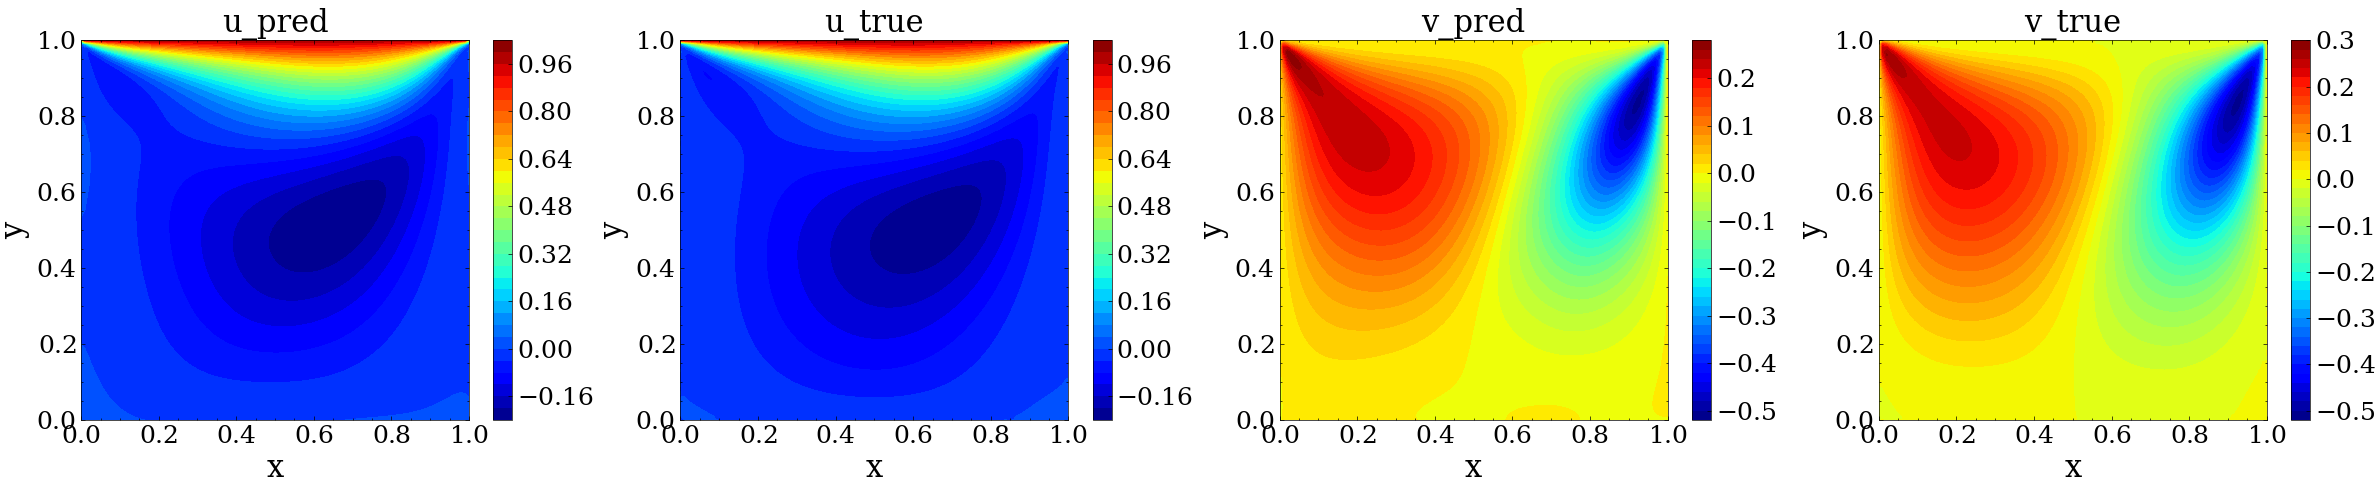

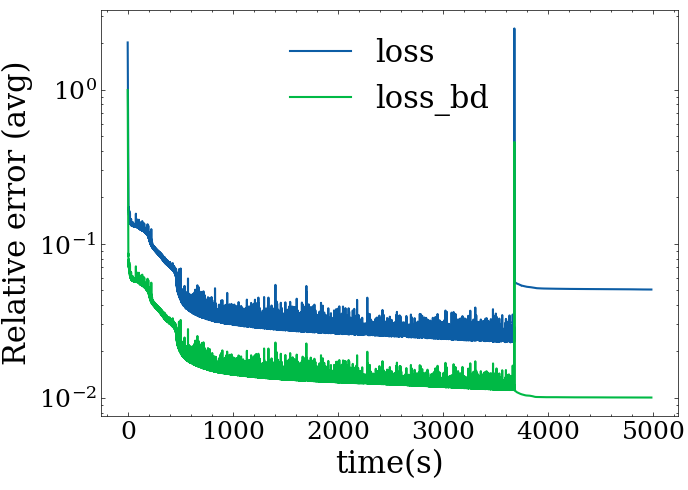

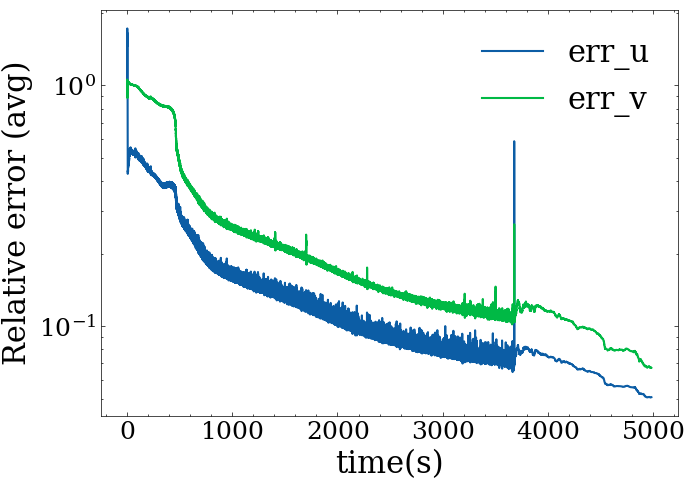

In [3]:
from Utils.PlotFigure import Plot
from Utils.Losses import *
from Solvers.PINN import PINN
myerror = MyLoss().lp_rel
# #####################################
# # load trained model
# #####################################
solver = PINN.Solver(device, dtype=dtype)
model_trained = solver.loadModel(path=f'saved_models/', name='model_pinn_final')

###############################
# make prediction
###############################
def get_values(x_device, solver, model_psip):
    psi_p = model_psip(x_device)
    psi, p = psi_p[...,0:1], psi_p[:,1:2]
    dpsi = solver.grad(psi, [x_device])[0]
    u, v = dpsi[...,1:2], -dpsi[...,0:1]
    
    return u, v, p
#
x_pred = Variable(x_test.to(device), requires_grad=True)
u_pred, v_pred, p_pred = get_values(x_pred, solver, model_trained['psi_p'])
#
u_pred = u_pred.detach().cpu()
v_pred = v_pred.detach().cpu()
p_pred = p_pred.detach().cpu()
#
print('The l2 error u is:', myerror(u_pred, u_test))
print('The l2 error v is:', myerror(v_pred, v_test))
######################################################
# show the solution
Plot.show_2d_list(x_test, [u_pred, u_test, v_pred, v_test], ['u_pred', 'u_true', 'v_pred', 'v_true'])
# show the loss
loss_saved = solver.loadLoss(path=f'saved_models/', name='loss_pinn')
Plot.show_error([loss_saved['time']]*2, 
                [loss_saved['loss'],  loss_saved['loss_bd']],['loss', 'loss_bd'])
# show the error
Plot.show_error([loss_saved['time']]*2, [loss_saved['error'][:,0], loss_saved['error'][:,1]], ['err_u', 'err_v'])